In [1]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Walmart_30k.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# If training from scratch, train this many times before averaging test set results. Train/val/test split is kept static.
TRAIN_REPEATS = 5
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=1
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import pandas as pd
import numpy as np
import torch

# Set up GPU if available
from torch import cuda
device = 'cuda' if cuda.is_available() and PREFER_GPU else 'cpu'
from sklearn import metrics
import os
import logging

print('Using {}'.format(device))

Using cuda


# Import data
Here we'll finally be using the randomly-sampled 750k-row subset.

In [3]:
data = pd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
with pd.option_context('display.max_colwidth', None):
    print (data.iloc[0])

title                                                        La Costena Chipotle Peppers, 7 OZ (Pack of 12)
description    La Costena Chipotle Peppers, 7 OZ (Pack of 12) Easy open. Ready to serve! Product of Mexico.
List Price                                                                                            31.93
Sale Price                                                                                            31.93
Brand                                                                                       La Costeï¿½ï¿½a
category                            [Food, Meal Solutions, Grains & Pasta, Canned Goods, Canned Vegetables]
Name: 0, dtype: object


# Categorical-encode the categories
For this notebook, we'll have a slightly weird encoding scheme: categories are ordered by their levels too. That is, in the numerical order will be all categories on the first level, THEN those on the second, so on and so forth.

The first step to achieving this would be to separate each level into their own column. Then, for categorical encoding to work, the columns themselves must be in pandas' `category` datatype, instead of the default `object` type for non-numerical columns.

From this, we can easily generate one-hot encodings for each level, which when concatenated gives the n-hot encoding for all categories.

In [4]:
def preprocess_classes(data, original_name, depth, verbose=False):
    """
    Build a list of unique class names for each level and create bidirectional mappings.
    """
    cls2idx = []
    idx2cls = []
    for i in range(depth): 
        category_li = data[original_name].apply(
            lambda lst: lst[i]
        ).astype('category')
        if verbose:
            print(category_li.cat.classes)
        cls2idx.append(dict([
            (category, index) 
            for (index, category) 
            in enumerate(category_li.cat.categories)
        ]))
        idx2cls.append(list(category_li.cat.categories))
    return cls2idx, idx2cls

cls2idx, idx2cls = preprocess_classes(data, CLASS_COL_NAME, DEPTH)    
print(cls2idx)
print('\n')
print(idx2cls)

[{'Arts Crafts & Sewing': 0, 'Auto & Tires': 1, 'Baby': 2, 'Beauty': 3, 'Books': 4, 'Cell Phones': 5, 'Character Shop': 6, 'Clothing': 7, 'Collectibles': 8, 'Electronics': 9, 'Feature': 10, 'Food': 11, 'Health': 12, 'Home': 13, 'Home Improvement': 14, 'Household Essentials': 15, 'Industrial & Scientific': 16, 'Jewelry': 17, 'Music': 18, 'Musical Instruments': 19, 'Office Supplies': 20, 'Party & Occasions': 21, 'Patio & Garden': 22, 'Personal Care': 23, 'Pets': 24, 'Premium Beauty': 25, 'Seasonal': 26, 'Sports & Outdoors': 27, 'Toys': 28, 'Video Games': 29, 'Walmart for Business': 30}, {'2-in-1 Hair and Body Care': 0, '@ Manual Shelves - Beauty': 1, '@ Manual Shelves - Food': 2, 'ATV & Off-Road': 3, 'Acid Reflux': 4, 'Action Figures': 5, 'Advance Auto Parts Shop': 6, 'Air Fresheners': 7, 'All Industrial': 8, 'Allergy and Sinus': 9, 'Appliances': 10, 'Aromatherapy': 11, 'Art Supplies': 12, 'Arts & Crafts for Kids': 13, 'As Seen On TV': 14, 'Audio': 15, 'Auto Body': 16, 'Auto Detailing & 

In [5]:
def class_to_index(data, original_name, cls2idx, depth):
    data['codes'] = data[original_name].apply(
        lambda lst: [
            cls2idx[i][cat] 
            for (i, cat) 
            in enumerate(lst[:depth])
        ]
    ).astype('object')

class_to_index(data, CLASS_COL_NAME, cls2idx, DEPTH)
data.head(10)

,title,description,List Price,Sale Price,Brand,category,codes
0,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)","La Costena Chipotle Peppers, 7 OZ (Pack of 12)...",31.93,31.93,La Costeï¿½ï¿½a,"[Food, Meal Solutions, Grains & Pasta, Canned ...","[11, 168]"
1,Equate Triamcinolone Acetonide Nasal Allergy S...,Compare to Nasacort Allergy 24HR active ingred...,10.48,10.48,Equate,"[Health, Equate, Equate Allergy, Equate Sinus ...","[12, 95]"
2,AduroSmart ERIA Soft White Smart A19 Light Bul...,The Soft White ERIA A19 bulb (2700K) can be co...,10.99,10.99,AduroSmart ERIA,"[Electronics, Smart Home, Smart Energy and Lig...","[9, 249]"
3,"24"" Classic Adjustable Balloon Fender Set Chro...","Lowrider Fender Set 24"" Classic Adjustable Chr...",38.59,38.59,lowrider,"[Sports & Outdoors, Bikes, Bike Accessories, B...","[27, 47]"
4,Elephant Shape Silicone Drinkware Portable Sil...,This is a kind of fine quality silicone cup l...,5.81,5.81,Anself,"[Baby, Feeding, Sippy Cups: Alternatives to Pl...","[2, 104]"
5,(6 Boxes) Twinings of London Nightly Calm Gree...,Enojy one of your favorite tea flavors with th...,17.99,17.99,Twinings,"[Food, Beverages, Tea, All Tea]","[11, 45]"
6,"Toytainer Shoe Box Play-N-Store, Boy","Toytainer Shoe Box Play-N-Store, Boy: Teach y...",11.52,11.52,Toytainer,"[Home, Kids Rooms, Kids Storage]","[13, 153]"
7,Dometic D1112002 D Line 3 N 1 Bowl Cleaner and...,Dometic D Line 3 N 1 Cleaner and Tank Treatmen...,34.41,34.41,Dometic,"[Household Essentials, Bathroom, Bathroom Clea...","[15, 34]"
8,"Tiny White Mighty Mints (16 oz, ZIN: 525424) -...","Tiny White Mighty Mints (16 oz, ZIN: 525424): ...",16.54,16.54,Larissa Veronica,"[Food, Chocolate, Candy & Gum, Mints, Shop All...","[11, 63]"
9,Diabetic Socks Small White - Item Number 11600...,Diabetic Socks Small White - Item Number 11600...,13.76,13.76,DJO,"[Health, Diabetes Care, Diabetic Socks]","[12, 79]"


We can try recovering category names from this encoding to ensure consistency:

In [6]:
def retrieve_classes(codes, idx2cls):
    return [ idx2cls[i][code] for (i, code) in enumerate(codes) ]

print('Original:', data.iloc[3]['category'][0:DEPTH])

print('Retrieved:', retrieve_classes(data['codes'].iloc[3], idx2cls))

Original: ['Sports & Outdoors' 'Bikes']
Retrieved: ['Sports & Outdoors', 'Bikes']


# Hierarchy generation
In this model, the hierarchical error penalty is simply $L_H = \lambda \times max(0,Y_{child} - Y_{parent})$. As such, we need to keep track of each node's parent and vectorise the calculation.

For now I'll be implementing this as simple arrays of category codes (in the global categorical space). We can then use these arrays of codes as vectorised indices to pull out $Y_{parent}$s and have our loss function somewhat vectorised too.

In [7]:
# TODO: Bring the above code into this thing's constructor entirely.
from functools import reduce
class PerLevelHierarchy:
    # level_sizes is a list of (distinct) class counts per hierarchical level.
    #   Its length dictates the maximum hierarchy construction depth.
    #   (that is, our above code)
    # classes is the list of distinct classes, in the order we have assembled.
    def __init__(self, data, cls2idx):
        self.levels = [ len(d.keys()) for d in cls2idx ] # TODO: Rename to level_sizes
        self.classes = reduce(lambda acc, elem: acc + elem, [ list(d.keys()) for d in cls2idx ], [])
        # Where each level starts in a global n-hot category vector
        # Its last element is coincidentally the length, which also allows us
        # to simplify the slicing code by blindly doing [offset[i] : offset[i+1]]
        self.level_offsets = reduce(lambda acc, elem: acc + [acc[len(acc) - 1] + elem], self.levels, [0])
        # Use -1 to indicate 'undiscovered'
        parent_of = [[-1] * level_size for level_size in self.levels] 
        for lst in data['codes']:
            # First-level classes' parent is root, but here we set them to themselves.
            # This effectively zeroes out the hierarchical loss for this level.
            parent_of[0][lst[0]] = lst[0]
            for i in range(1, len(self.levels)):
                child_idx = lst[i]
                parent_idx = lst[i-1]
                if parent_of[i][child_idx] == -1:
                    parent_of[i][child_idx] = parent_idx
            self.parent_of = []
            for parent_lst in parent_of:
                self.parent_of.append(torch.LongTensor(parent_lst).to(device))

In [8]:
hierarchy = PerLevelHierarchy(data, cls2idx)
hierarchy.parent_of

[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], device='cuda:0'),
 tensor([23,  3, 11,  1, 12, 28,  1, 15, 16, 12, 13, 12,  0, 28, 15,  9,  1,  1,
          1,  1,  1,  1,  1,  2,  2,  2,  3, 26, 12,  7, 11, 21, 13, 23, 15, 14,
         15,  0,  3,  3,  3,  3,  3, 13, 12, 11,  7, 27, 17, 11, 30,  4, 21,  9,
          1,  2, 12, 24,  5,  7,  4, 12, 12, 11, 21, 23, 26, 15,  3, 11, 12,  9,
         11,  4,  6, 13, 23,  3, 20, 12, 12, 12, 12,  2, 12,  6, 28, 24, 24, 28,
         15, 12, 14, 28, 14, 12, 27,  1, 12, 12, 24,  7, 16, 13,  2, 23, 12, 12,
         16, 12,  3,  3, 11, 11, 11, 13,  9, 28, 22, 12, 11, 21, 11, 22, 14,  3,
         21,  3, 14, 12,  2, 12, 14,  3,  4, 28, 13, 12, 14, 24, 22,  4, 15, 23,
         19, 21, 16, 21,  7, 12, 28,  7, 17, 13, 13, 11,  4, 26, 15, 12, 28, 15,
         12,  4,  3, 21, 12,  7, 11, 16, 12, 12,  7,  7, 23, 23,  3, 12,  1,  3,
          7, 10,  6,  2,  1, 

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [9]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

One point of interest is how we do not explicitly store per-level one-hot encodings. Here we simply store one global copy (n-hot-encoded) then slice from it when requested, saving a bit of memory.

In [10]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, df, hierarchy, tokenizer, max_len, text_col_name = TEXT_COL_NAME):
    self.tokenizer = tokenizer
    self.text = df[text_col_name]
    # Level sizes
    self.levels = hierarchy.levels
    self.labels = df.codes
    self.level_offsets = hierarchy.level_offsets
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text.iloc[index])
    text = " ".join(text.split())
    inputs = self.tokenizer(
      text,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      truncation=True
      # BERT tokenisers return attention masks by default
    )

    labels = torch.tensor(self.labels.loc[index], dtype=torch.long)

    result = {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'labels': labels,
    }

    return result

Regarding that `max_len` hyperparameter, let's see the distribution of title:

<AxesSubplot:>

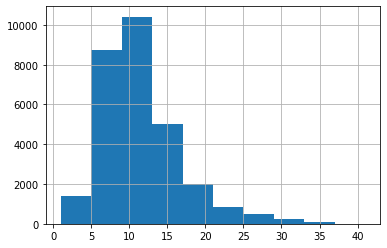

In [11]:
data['title_len'] = data['title'].apply(lambda s: len(s.split()))
data['title_len'].hist()

We prefer `max_len` to be a power of two that covers most of the titles.

In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 64
LINEAR_DROPOUT_RATE = 0.3
TRAIN_MINIBATCH_SIZE = 16
VAL_TEST_MINIBATCH_SIZE = 64
EPOCHS = 5
ENCODER_LEARNING_RATE = 3e-05
CLASSIFIER_LEARNING_RATE = 3e-03
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
# Don't change this if you want a consistent sampling for easier comparisons
RANDOM_SEED = 123

FULL_SET = False
PARTIAL_SET_FRAC = 0.1

CV-split our dataset:

In [13]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = PARTIAL_SET_FRAC, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'codes']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS]
else:
    filtered = small_data[COLUMNS]

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(2337, 2)
(292, 2)
(292, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [14]:
train_set_wrapped = CustomDataset(train_set, hierarchy, tokenizer, MAX_LEN)
val_set_wrapped = CustomDataset(val_set, hierarchy, tokenizer, MAX_LEN)
test_set_wrapped = CustomDataset(test_set, hierarchy, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(dataset=train_set_wrapped, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by our implementation of HMCN-F.

### DB-FBHCN
This is our hybrid between HMCN-F and our simpler BERT-linear model.

The idea is simple: one layer per hierarchical level. First layer takes in 768 BERT features (we might want to pool it later) and output $h_1$ values corresponding to scores for all categories at the first level. The second layer takes in this prediction, plus 768 original BERT features, and output $h_2$ values corresponding to scores for all categories on the second level, and so on.

The final hierarchical prediction is simply the concatenation of predictions from each level, from first to last. Each would have already been through a sigmoid function before being concatenated, but that would be done outside of the model for performance reasons.

Right now the global loss calculation is simply the sum of losses of each level. For this reason we make the model output each level separately. That way we can also easily argmax on each level to get the category names.

We'll keep the hierarchical loss, as it is important in keeping the levels in sync.

In [15]:
import torch
from tqdm.notebook import tqdm

class DBFBHCN(torch.nn.Module):
    def __init__(
        self, 
        feature_size, 
        dropout_rate, # after every linear layer
        hierarchy,
        hidden_nonlinear='relu'
    ):
        super(DBFBHCN, self).__init__()

        # Back up some parameters for use in forward()
        self.depth = len(hierarchy.levels)

        # First layer only takes in BERT encodings
        self.fc_layers = torch.nn.ModuleList([ 
            torch.nn.Linear(feature_size, hierarchy.levels[0])
        ])
        torch.nn.init.xavier_uniform_(self.fc_layers[0].weight)
        self.norms = torch.nn.ModuleList([])
        for i in range(1, self.depth):
            self.fc_layers.extend([ 
                torch.nn.Linear(feature_size + hierarchy.levels[i-1], hierarchy.levels[i]) 
            ])
            torch.nn.init.xavier_uniform_(self.fc_layers[i].weight)
            self.norms.extend([torch.nn.LayerNorm(hierarchy.levels[i-1], elementwise_affine=False)])
        # Activation functions
        self.hidden_nonlinear = torch.nn.ReLU() if hidden_nonlinear == 'relu' else torch.nn.Tanh()
        self.output_nonlinear = torch.nn.LogSoftmax(dim=1)

        # Dropout
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # We have |D| of these
        local_outputs = []
        output_l1 = self.fc_layers[0](self.dropout(x))
        local_outputs.append(self.output_nonlinear(output_l1))

        prev_output = self.hidden_nonlinear(output_l1)
        for i in range(1, self.depth):
            output_li = self.fc_layers[i](torch.cat([self.dropout(self.norms[i-1](prev_output)), x], dim=1))
            local_outputs.append(self.output_nonlinear(output_li))
            prev_output = self.hidden_nonlinear(output_li)

        return local_outputs

## Checkpoints
PyTorch allows us to save the best-performing model automatically so we can restart from that instead of the beginning. No reason not to do that.

In [16]:
import shutil, sys
def load_checkpoint(checkpoint_fpath, model):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    
    encoder, classifier = model
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    encoder.load_state_dict(checkpoint['encoder_state_dict'])

    # return model, optimizer, epoch value, min validation loss 
    return (encoder, classifier)

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """

    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Training time
## Metrics
We define hierarchical accuracy as simply the averaged accuracy over each level. Same for precision.
This is a big TODO item: get something more representative for metrics.

In [17]:
from sklearn import metrics
def get_metrics(local_outputs, targets, log_metrics = False, get_auprc = False):
    leaf_size = local_outputs[-1].shape[1]
    def generate_one_hot(idx):
        b = np.zeros(leaf_size, dtype=bool)
        b[idx] = 1
        return b

    level_codes = [ 
        np.argmax(local_outputs[level], axis=1) 
        for level in range(len(local_outputs)) 
    ]
    
    accuracies = [ metrics.accuracy_score(level_codes[level], targets[:, level]) for level in range(len(hierarchy.levels)) ]
    precisions = [ metrics.precision_score(level_codes[level], targets[:, level], average='weighted', zero_division=0) for level in range(len(local_outputs)) ]
    
    global_accuracy = sum(accuracies)/len(accuracies)
    global_precision = sum(precisions)/len(precisions)
    
    if log_metrics:
        logging.info('Leaf level:')
        logging.info("Accuracy: {}".format(accuracies[-1]))
        # Model Precision: what percentage of positive tuples are labeled as such?
        logging.info("Precision: {}".format(precisions[-1]))

        logging.info('Global level:')
        logging.info("Accuracy: {}".format(global_accuracy))
        # Model Precision: what percentage of positive tuples are labeled as such?
        logging.info("Precision: {}".format(global_precision))
    
    if get_auprc:
        binarised_targets = np.array([generate_one_hot(lst[-1]) for lst in test_result['targets']])

        # Rectified leaf AU(PRC) due to an sklearn bug.
        # We add one artificial example that belongs to all classes at once and a corresponding prediction
        # full of true positives. This way each class has at least one true positive, even if the test set
        # does not contain enough examples to cover all classes.
        rectified_outputs = np.concatenate([test_result['outputs'][-1], np.ones((1, leaf_size))], axis=0)
        rectified_targets = np.concatenate([binarised_targets, np.ones((1, leaf_size), dtype=bool)], axis=0)
        auprc = metrics.average_precision_score(rectified_targets, rectified_outputs)
        if log_metrics:
            logging.info('Rectified leaf-level AU(PRC) score: {}'.format(auprc))
    
        return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision, auprc])
    return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision])

## Training script

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

For now we'll stick with one of the provided loss functions instead of building anything radical. As we are performing multiclass classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary). The way we use them however, is a bit different. We'll have two types of loss values:
- A leaf-level loss value, that is, $L_L = NLL(y_{leaf}, \bar{y}_{leaf})$, and
- A hierarchical loss value $L_H = NLL(y_{parent}, \bar{y}_{parent})$ for every level except leaf, summed up. That is, we will enforce that each level must predict the parent of whatever the next level predicted, even if they are wrong, creating a bottom-up hierarchy tracing strategy. This will be kept at a lower significance than the leaf-level loss due to its tendency to explode and knocking our gradient descent out of a good path.

The final loss is then defined as $L = \lambda_L L_L + \lambda_H L_H$ where $\lambda_H$ is likely to be smaller than $\lambda_L$.

We also construct our optimiser here, which is Adam with different learning rates for DistilBERT and our model.

All of these are put inside a `train_model` function for brevity.

In [18]:
from tqdm.notebook import tqdm

def train_model(checkpoint_path, best_model_path, start_epochs, n_epochs, val_loss_min_input, 
                training_loader, val_loader, model, hierarchy, lambda_L, lambda_H, gamma_L, verbose=False
                ):
    encoder, classifier = model
    
    depth = len(hierarchy.levels)
    
    criterion = torch.nn.NLLLoss()
    criterion_h = torch.nn.NLLLoss(reduction='none')

    optimizer = torch.optim.Adam(
        [
            {'params': encoder.parameters(), 'lr': ENCODER_LEARNING_RATE},
            {'params': classifier.parameters(), 'lr': CLASSIFIER_LEARNING_RATE}
        ], 
    )
    
    deviations = np.linspace(-gamma_L, gamma_L, depth)
    loss_L_weights = [1] * depth
    loss_L_weights -= deviations
    print('Using level weights', loss_L_weights, 'for local loss.')

    optimizer = torch.optim.Adam(
        [
            {'params': encoder.parameters(), 'lr': ENCODER_LEARNING_RATE,},
            {'params': classifier.parameters(), 'lr': CLASSIFIER_LEARNING_RATE}
        ], 
    )

    # Keep min validation loss so we can separately back up our best-yet model
    val_loss_min = val_loss_min_input
    
    # Store validation metrics after each epoch
    val_metrics = np.empty((4, 0), dtype=float)
    
    for epoch in range(start_epochs, n_epochs+1):
        train_loss = 0
        # Put model into training mode. Note that this call DOES NOT train it yet.
        encoder.train()
        classifier.train()
        print('Epoch {}: Training'.format(epoch))
        for batch_idx, data in enumerate(tqdm(training_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels']#.to(device, dtype = torch.long)

            features = encoder(ids, mask)[0][:,0,:]
            local_outputs = classifier(features)

            # We have two loss functions: (l)ocal (per-level), and (h)ierarchical.
            loss_l = lambda_L * sum([ criterion(
                local_outputs[level].cpu(),
                targets[:, level]
            ) * loss_L_weights[level] for level in range(depth) ])
            
            # Hierarchically penalise less (or don't at all) if the prediction itself is wrong at the child level.
            loss_h_levels = []
            for level in range(depth-1):
                target_child_indices = torch.unsqueeze(targets[:, level + 1], 1).to(device)
                transformed = local_outputs[level + 1] * -1
                transformed -= transformed.min(1, keepdim=True)[0]
                transformed /= transformed.max(1, keepdim=True)[0]
                loss_factors = 1 - torch.squeeze(transformed.gather(1, target_child_indices), 1)
                loss_h_levels.append(
                    torch.mean(criterion_h(
                        local_outputs[level], 
                        torch.index_select(
                            hierarchy.parent_of[level + 1],
                            0, 
                            torch.argmax(local_outputs[level + 1], dim=1)
                        )
                    ) * loss_factors)
                )
            loss_h = lambda_H * sum(loss_h_levels)
            loss = loss_l + loss_h

            # PyTorch defaults to accumulating gradients, but we don't need that here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

        print('Epoch {}: Validating'.format(epoch))


        # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
        encoder.eval()
        classifier.eval()
        val_loss = 0

        val_targets = np.empty((0, len(hierarchy.levels)), dtype=bool)
        val_outputs = [np.empty((0, hierarchy.levels[level]), dtype=float) for level in range(len(hierarchy.levels))]

        # We're only testing here, so don't run the backward direction (no_grad).
        with torch.no_grad():
            total_loss_l = 0
            total_loss_h = 0
            for batch_idx, data in enumerate(tqdm(val_loader)):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['labels']#.to(device, dtype = torch.long)

                features = encoder(ids, mask)[0][:,0,:]
                local_outputs = classifier(features)

                # We have two loss functions: (l)ocal (per-level), and (h)ierarchical.
                loss_l = lambda_L * sum([ criterion(
                    local_outputs[level].cpu(),
                    targets[:, level]
                ) * loss_L_weights[level] for level in range(depth) ])

                # Hierarchically penalise less (or don't at all) if the prediction itself is wrong at the child level.
                loss_h_levels = []
                for level in range(depth-1):
                    target_child_indices = torch.unsqueeze(targets[:, level + 1], 1).to(device)
                    transformed = local_outputs[level + 1] * -1
                    transformed -= transformed.min(1, keepdim=True)[0]
                    transformed /= transformed.max(1, keepdim=True)[0]
                    loss_factors = 1 - torch.squeeze(transformed.gather(1, target_child_indices), 1)
                    loss_h_levels.append(
                        torch.mean(criterion_h(
                            local_outputs[level], 
                            torch.index_select(
                                hierarchy.parent_of[level + 1],
                                0, 
                                torch.argmax(local_outputs[level + 1], dim=1)
                            )
                        ) * loss_factors)
                    )
                loss_h = lambda_H * sum(loss_h_levels)
                loss = loss_l + loss_h
                
                total_loss_l += loss_l
                total_loss_h += loss_h

                val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)

                val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
                
                for i in range(len(val_outputs)):
                    val_outputs[i] = np.concatenate([val_outputs[i], local_outputs[i].cpu().detach().numpy()])

        val_metrics = np.concatenate([val_metrics, 
            np.expand_dims(
                get_metrics(val_outputs, val_targets), axis=1
            )],
            axis=1
        )
        
        train_loss = train_loss/len(training_loader)
        val_loss = val_loss/len(val_loader)
        
        if verbose:
            # Calculate average losses
            print('Average minibatch local loss:', total_loss_l / len(val_loader))
            print('Average minibatch hierarchical loss:', total_loss_h / len(val_loader))

            # Print training/validation statistics
            print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
                train_loss,
                val_loss
            ))

        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'encoder_state_dict': encoder.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        best_yet = False
        if val_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
            # save checkpoint as best model
            best_yet = True
            val_loss_min = val_loss
        save_checkpoint(checkpoint, best_yet, checkpoint_path, best_model_path)
        print('Epoch {}: Done\n'.format(epoch))
    return (encoder, classifier), val_metrics

# Alternative: just load from disk
def run_model(model, loader, hierarchy):
  encoder, classifier = model
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  encoder.eval()
  classifier.eval()

  all_targets = np.empty((0, len(hierarchy.levels)), dtype=bool)
  all_outputs = [np.empty((0, hierarchy.levels[level]), dtype=float) for level in range(len(hierarchy.levels))]

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].to(device, dtype = torch.long)

      features = encoder(ids, mask)[0][:,0,:]
      local_outputs = classifier(features)

      all_targets = np.concatenate([all_targets, targets.cpu().detach().numpy()])
      for i in range(len(all_outputs)):
        all_outputs[i] = np.concatenate([all_outputs[i], local_outputs[i].cpu().detach().numpy()])

  return {
      'targets': all_targets,
      'outputs': all_outputs,
  }

In [19]:
folder_name = 'checkpoints-avg-' + DATASET_NAME
!mkdir $folder_name
checkpoint_idx_path = "{}/last_idx".format(folder_name)

# Set up current checkpoint index
CHECKPOINT_IDX = 0
if os.path.exists(checkpoint_idx_path):
    idx_file = open(checkpoint_idx_path, 'r')
    CHECKPOINT_IDX = int(idx_file.read()) + 1
    idx_file.close()
idx_file = open(checkpoint_idx_path, 'w')
idx_file.write(str(CHECKPOINT_IDX))
idx_file.close()

logging.basicConfig(filename="{}/{}.log".format(folder_name, CHECKPOINT_IDX), level=logging.INFO)

all_test_metrics = np.zeros((TRAIN_REPEATS, 5), dtype=float)

trained_model = None
if TRAIN_FROM_SCRATCH:
    for i in range(TRAIN_REPEATS):
        run_header = "--- RUN {} ---".format(i)
        print(run_header)
        logging.info(run_header)
        # Reinitialise weights
        encoder = base_encoder
        encoder.load_state_dict(base_encoder_state)
        encoder.to(device)
        classifier = DBFBHCN(
            768, # DistilBERT outputs 768 values.
            dropout_rate = LINEAR_DROPOUT_RATE,
            hierarchy=hierarchy,
            hidden_nonlinear='relu',
        )
        classifier.to(device)
        
        # Train/validate
        CHECKPOINT_PATH = './{}/{}_{}_current.pt'.format(folder_name, CHECKPOINT_IDX, i)
        BEST_CHECKPOINT_PATH = './{}/{}_{}_best.pt'.format(folder_name, CHECKPOINT_IDX, i)
        trained_model, val_metrics = train_model(
            CHECKPOINT_PATH,
            BEST_CHECKPOINT_PATH,
            1, # Count from one
            EPOCHS,
            np.Inf, 
            train_loader, 
            val_loader, 
            (encoder, classifier), 
            hierarchy,
            1.0, # lambda_L
            0.7, # lambda_H
            -0.25 # gamma_L
        )
        
        # Test
        test_result = run_model(trained_model, test_loader, hierarchy)
        test_metrics = get_metrics(test_result['outputs'], test_result['targets'], True, True)
        all_test_metrics[i, :] = test_metrics
    averaged = np.average(all_test_metrics, axis = 0)
    averaged_display = '--- Average of {} runs:\nLeaf accuracy: {}\nLeaf precision: {}\nPath accuracy: {}\nPath precision: {}\nLeaf AU(PRC): {}'.format(
        TRAIN_REPEATS, averaged[0], averaged[1], averaged[2], averaged[3], averaged[4])
    print(averaged_display)
    logging.info(averaged_display)
else:
    load_path = '{}/{}_{}_{}.pt'.format(folder_name, LOAD_ITERATION, TRAIN_REPEATS - 1, 'best' if LOAD_BEST else 'current')
    trained_model, _ = load_checkpoint(load_path, (encoder, classifier))
    # Test
    test_result = run_model(trained_model, test_loader, hierarchy)
    get_metrics(test_result['outputs'], test_result['targets'], True, True)

mkdir: cannot create directory ‘checkpoints-avg-Walmart_30k.parquet’: File exists
--- RUN 0 ---
Using level weights [0.75 1.25] for local loss.
Epoch 1: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.2426)
Average minibatch hierarchical loss: tensor(0.2786, device='cuda:0')
Avgerage training loss: 0.034358
Average validation loss: 0.704234
Validation loss decreased (inf --> 0.704234).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Done

Epoch 2: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 2: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(2.9858)
Average minibatch hierarchical loss: tensor(0.1664, device='cuda:0')
Avgerage training loss: 0.016670
Average validation loss: 0.630434
Validation loss decreased (0.704234 --> 0.630434).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Done

Epoch 3: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 3: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.2912)
Average minibatch hierarchical loss: tensor(0.1221, device='cuda:0')
Avgerage training loss: 0.009286
Average validation loss: 0.682671


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Done

Epoch 4: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 4: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.3898)
Average minibatch hierarchical loss: tensor(0.1914, device='cuda:0')
Avgerage training loss: 0.005254
Average validation loss: 0.716224


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Done

Epoch 5: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 5: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.8629)
Average minibatch hierarchical loss: tensor(0.2088, device='cuda:0')
Avgerage training loss: 0.002652
Average validation loss: 0.814348


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Done



  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rectified leaf-level AU(PRC) score: 0.9378611757998514
--- RUN 1 ---
Using level weights [0.75 1.25] for local loss.
Epoch 1: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.1726)
Average minibatch hierarchical loss: tensor(0.2358, device='cuda:0')
Avgerage training loss: 0.033613
Average validation loss: 0.681686
Validation loss decreased (inf --> 0.681686).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Done

Epoch 2: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 2: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(2.7769)
Average minibatch hierarchical loss: tensor(0.2084, device='cuda:0')
Avgerage training loss: 0.016257
Average validation loss: 0.597061
Validation loss decreased (0.681686 --> 0.597061).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Done

Epoch 3: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 3: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.0405)
Average minibatch hierarchical loss: tensor(0.1965, device='cuda:0')
Avgerage training loss: 0.009108
Average validation loss: 0.647395


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Done

Epoch 4: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 4: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.5531)
Average minibatch hierarchical loss: tensor(0.2386, device='cuda:0')
Avgerage training loss: 0.004226
Average validation loss: 0.758339


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Done

Epoch 5: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 5: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(4.0517)
Average minibatch hierarchical loss: tensor(0.1667, device='cuda:0')
Avgerage training loss: 0.002087
Average validation loss: 0.843683


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Done



  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rectified leaf-level AU(PRC) score: 0.9371504887974739
--- RUN 2 ---
Using level weights [0.75 1.25] for local loss.
Epoch 1: Training


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1: Validating


  0%|          | 0/5 [00:00<?, ?it/s]

Average minibatch local loss: tensor(3.3144)
Average minibatch hierarchical loss: tensor(0.2028, device='cuda:0')
Avgerage training loss: 0.033709
Average validation loss: 0.703439
Validation loss decreased (inf --> 0.703439).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Done

Epoch 2: Training


  0%|          | 0/147 [00:00<?, ?it/s]

KeyboardInterrupt: 